# Fetal Anomalies Detection



Installs and imports:

In [1]:
!pip install xgboost
!pip install ucimlrepo # retrieve dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xgboost as xgb
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from io import StringIO
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

## **Goal**

The goal of this project is to develop a predictive model to identify potential fetal anomalies using data from Cardiotocography (CTG). CTG is a widely used, non-invasive method to monitor fetal heart rate and uterine contractions, making it an ideal tool for assessing fetal well-being. This model aims to assist healthcare professionals in early diagnosis and intervention by predicting whether the outcome is normal, suspect, or pathological, based on features extracted from CTG data.


### **Steps**:
1. **Dataset Exploration**:
  - Understand the structure and contents of the dataset, including the features and their distribution.
   - Investigate class imbalance in the target variable (normal, suspect, pathological).
   - Visualize important features and correlations between them.

2. **Data Preprocessing**:
   - Clean and prepare the dataset by selecting relevant features and handling missing values.
   - Standardize the features to ensure that the model performs well across different scales.
  
2. **Model Development**:
   - Implement a machine learning model (XGBoost) capable of handling imbalanced datasets.
   - Optimize hyperparameters to enhance model performance.
   
3. **Model Evaluation**:
   - Evaluate the model based on metrics such as accuracy, precision, recall, and the F1 score to assess its effectiveness.
   - Use cross-validation to ensure the model's robustness and generalization.

4. **Deployment**:
   - Save the trained model in a format (json) that can be easily integrated into a web-based API for inference.
   - Provide a skeleton framework for deployment using Flask and Docker to make the model accessible to healthcare providers.

## Dataset

- The dataset used for this project comes from Cardiotocography records and is part of the UC Irvine ML Repository.

The dataset contains the following features:
- LB - FHR baseline (beats per minute)
- AC - # of accelerations per second
- FM - # of fetal movements per second
- UC - # of uterine contractions per second
- DL - # of light decelerations per second
- DS - # of severe decelerations per second
- DP - # of prolongued decelerations per second
- ASTV - percentage of time with abnormal short term variability
- MSTV - mean value of short term variability
- ALTV - percentage of time with abnormal long term variability
- MLTV - mean value of long term variability
- Width - width of FHR histogram
- Min - minimum of FHR histogram
- Max - Maximum of FHR histogram
- Nmax - # of histogram peaks
- Nzeros - # of histogram zeros
- Mode - histogram mode
-Mean - histogram mean
- Median - histogram median
- Variance - histogram variance
- Tendency - histogram tendency


The dataset contains the following labels:

- CLASS - FHR pattern class code (1 to 10)
- NSP - fetal state class code (N=normal; S=suspect; P=pathologic)

As stated in the official dataset source: "The CTGs were also classified by three expert obstetricians and a consensus classification label assigned to each of them. Classification was both with respect to a morphologic pattern (A, B, C...) and to a fetal state (N, S, P)." It is therefore reasonable to have high confidence in the quality and reliability of the dataset, as it reflects expert medical judgment and consensus.

In this project, classification will be performed on the NSP labels, which indicate the fetal state as normal, suspect, or pathological. This aligns with the project's goal of predicting potential fetal anomalies, as these labels provide a clear medical assessment of fetal health.

Dataset retrieval:

In [3]:
cardiotocography = fetch_ucirepo(id=193)

X = cardiotocography.data.features
y = cardiotocography.data.targets['NSP']

print("\nDataset Shape:")
print(f"  - Features shape: {X.shape}")
print(f"  - Target shape: {y.shape}")


Dataset Shape:
  - Features shape: (2126, 21)
  - Target shape: (2126,)


Assessment of missing variables:

In [4]:
print("\nMissing Values in the Dataset:")
print(X.isnull().sum())


Missing Values in the Dataset:
LB          0
AC          0
FM          0
UC          0
DL          0
DS          0
DP          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
dtype: int64


No need to deal with missing values.

Label distribution:


Target Class Distribution (Counts):
NSP
1    1655
2     295
3     176
Name: count, dtype: int64


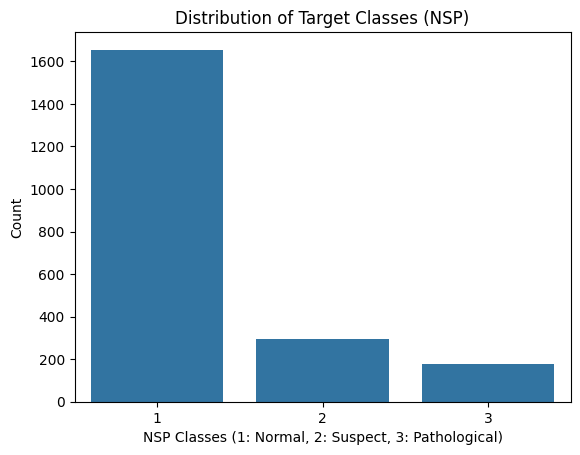

In [5]:
label_counts = y.value_counts()
print("\nTarget Class Distribution (Counts):")
print(label_counts)

sns.countplot(x=y)
plt.title("Distribution of Target Classes (NSP)")
plt.xlabel("NSP Classes (1: Normal, 2: Suspect, 3: Pathological)")
plt.ylabel("Count")
plt.show()


There is a clear imbalance in the dataset, where the normal cases vastly outnumber the suspect and pathological cases. Such class imbalance is common in medical datasets but poses a challenge for machine learning models, which may become biased towards the majority class (Normal). This imbalance will be addressed in the following Model Training section by properly tuning the model and by using proper performance metrics.

## Pre-processing

Turning categorical labels into numerical:

In [6]:
y = y - 1

Dataset splitting into training set and test set:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Dataset scaling:

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fitting only on training set to avoid data leakage
X_test = scaler.transform(X_test)

## Model training

Dealing with class imbalance: class weights.

In [9]:
# Estimate scale_pos_weight based on class distribution
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weight = class_weights[1] + class_weights[2] / class_weights[0]

print(scale_pos_weight)

11.42977449026694


In [10]:
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Why XGBoost?
*   State of the art performance on strcutured numerical data
*   Robust with respect to overfitting
*   Fast and light
*   Built-in functionality to deal with unbalanced labels

Why not neural networks?
*   They do not excel in structured scenarios
*   Prone to overfitting
*   Complex and expensive to train and deploy

Training process for the imbalanced dataset:

1. Resampling with SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution in the training data by generating synthetic samples for minority classes.

2. Computing Class Weights: Class weights are computed to reflect the distribution of classes in the resampled dataset, adjusting the model's sensitivity to class imbalances.

3. Creating Sample Weights: Sample weights are generated from the class weights, indicating the importance of each training example during model training.

4. Training the Model: XGBoost classifier is trained on the resampled dataset using the computed sample weights to improve performance on imbalanced classes and handle the class imbalance effectively.



In [11]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Convert class weights to sample weights
sample_weights = np.array([class_weights_dict[class_label] for class_label in y_train_resampled])

# Create and train the model
model = xgb.XGBClassifier(
    eval_metric='mlogloss'
)

# Fit resampled data with sample weights
model.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

## Evaluation

The key column in this scenario is the first one (examples predict as normal), as it is key to avoid false negatives (suspect/pathologic cases labeled as normal), but it is fine to have false positives (normal cases labeled as suspect/pathologic).

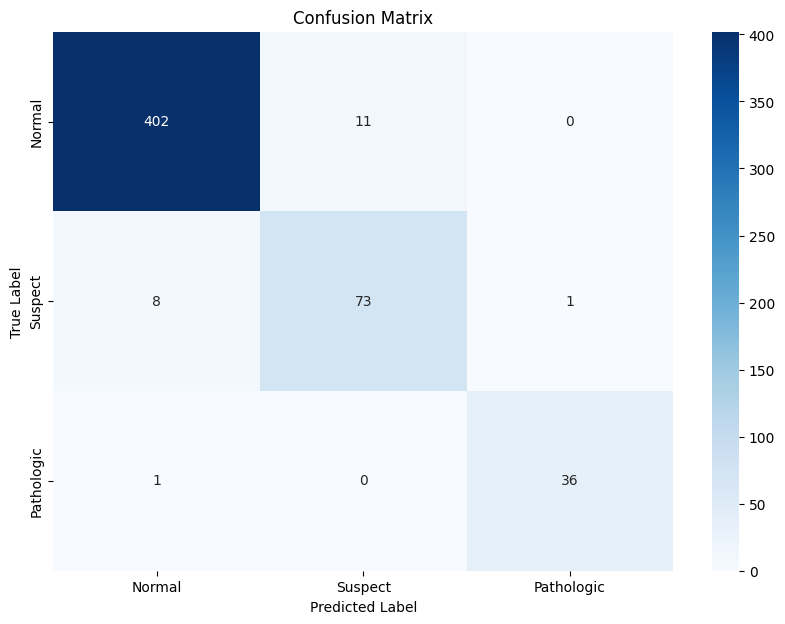

In [12]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Labels for the classes
labels = ['Normal', 'Suspect', 'Pathologic']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Out of the 142 suspect/pathological examples in the test set, only 9 are falsely labeled as normal and therefore problematic.

In [13]:
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98       413
     Suspect       0.87      0.89      0.88        82
  Pathologic       0.97      0.97      0.97        37

    accuracy                           0.96       532
   macro avg       0.94      0.95      0.94       532
weighted avg       0.96      0.96      0.96       532



Recall is high for all classes.

The following shows the feature importance according to this model. Feature importance is not only useful to get a sense of which features are most relevant for the task at hand, but also in the case of model pruning, as it helps identify and remove features that contribute less to the model's performance.

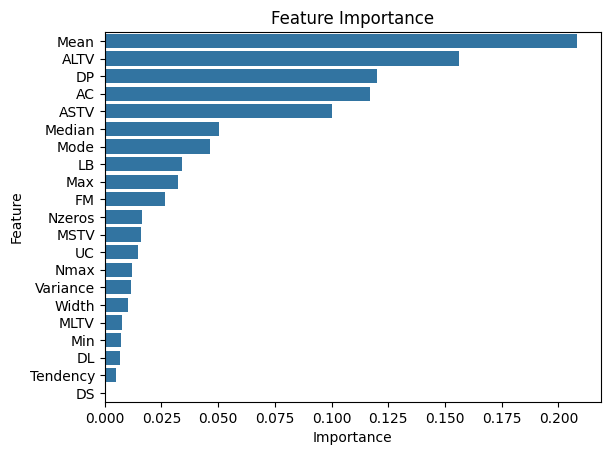

In [14]:
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

Some features appear to have little relevance and might be pruned.
Model pruning can make the model simpler to use and understand, decrease inference time and overfitting.
In this case however the model is already light and fast and achieving the highest confidence is paramount, therefore all features are kept for the deployment.

## Deployment

The model and the scaler are serialized and downloaded to be then deployed via a web application.

In [15]:
import joblib

# Save the XGBoost model
model.get_booster().save_model('xgboost_fetal_anomalies_model.json')

# Save the scaler using joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Conclusion
In this project, a predictive model using XGBoost to identify fetal anomalies based on Cardiotocography (CTG) data was developed and evalutaed. By addressing class imbalance with techniques like SMOTE and optimizing model performance through feature scaling, high recall across all classes was achieved. This model is now ready for deployment, with both the model and scaler saved for real-time inference, supporting obstetricians in detecting fetal anomalies at an early stage.
